In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'1.15.2'

In [2]:
import zipfile
with zipfile.ZipFile('./sign_type_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [3]:
from PIL import Image
import pandas as pd
import glob
image_list = []
for filepath in glob.glob('./sign_type_data/*/*.png', recursive=True): #assuming gif
    filename = filepath.split("/")[-1]
    label = filepath.split("/")[-2]
#     print(filepath, filename, label)
    image_list.append((filepath, label))
#     print(filepath, label)
    
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'label'])

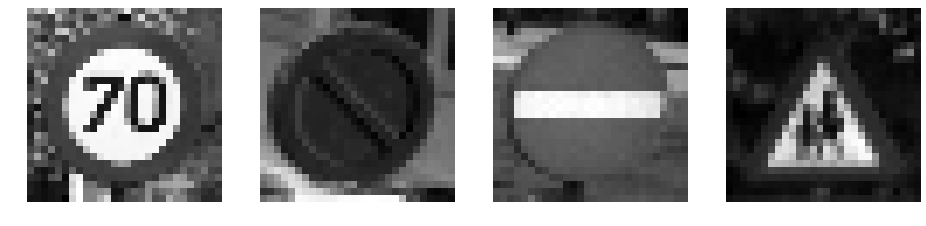

In [4]:
r_inx = np.random.choice(2000, 4)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

In [5]:
data.sample(frac=1)

,image_path,label
1665,./sign_type_data/warning/00201_00000.png,warning
356,./sign_type_data/noparking/01822_00002.png,noparking
3548,./sign_type_data/rightofway/00547_00000.png,rightofway
1715,./sign_type_data/warning/01580_00002.png,warning
655,./sign_type_data/laneend/00144_00002.png,laneend
895,./sign_type_data/noentry/01118_00001.png,noentry
900,./sign_type_data/noentry/00956_00001.png,noentry
2847,./sign_type_data/parking/00482_00002.png,parking
446,./sign_type_data/noparking/00460_00000.png,noparking
144,./sign_type_data/giveway/01876_00002.png,giveway


In [6]:
# Convert string labels to numeric
# d = {'diamond':0, 'hex':1, 'square':2, 'triangle':3}
# data['labels_num'] = data['label'].map(d, na_action='ignore')

# Generate two data frames for training and validation
first_split = data.sample(frac=0.8).reset_index()
# print(first_split)
second_split= data.drop(first_split.index)
# print(second_split)

print('Train size: {}, Test size: {}'.format(first_split.shape[0], second_split.shape[0] ) )
N_train_images = first_split.shape[0]
N_val_images = second_split.shape[0]

Train size: 2959, Test size: 740


In [7]:
from sklearn.model_selection import train_test_split

train_df, validation_df = train_test_split(data, test_size=0.2)

In [8]:
batch_size = 16

In [9]:
def calculate_losses(model_in, data_generator_in, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    
    # iterate over each batch
    for x,y in data_generator_in:
        loss, acc = model_in.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
            
    return np.mean(loss_hold), np.mean(acc_hold)

In [10]:
def train_model(model_, train_generator_in, validation_generator_in, num_epoch=50, verbose=False):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator_in:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator_in, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

In [11]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model_cnn = Sequential()

# input
model_cnn.add(Input(shape=(28, 28, 3)))
model_cnn.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 (no pooling)
model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation('relu'))

# Conv Layer 3
model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# MLP
model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(16))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

# save the weights so that we can start from the same place when tring different configurations
model_cnn.save_weights('model.h5')

model_cnn.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 32)        0         
_________________________________________

Training epoch 0: Loss = 2.174715995788574, Accuracy = 0.3468693792819977
Validation epoch 0: Loss = 1.0482343257741724, Accuracy = 0.728723406791687
Training epoch 1: Loss = 0.8848778009414673, Accuracy = 0.7548423409461975
Validation epoch 1: Loss = 0.36242878484599134, Accuracy = 0.9055851101875305
Training epoch 2: Loss = 0.5330501794815063, Accuracy = 0.8474323749542236
Validation epoch 2: Loss = 0.2492521769822912, Accuracy = 0.9481382966041565
Training epoch 3: Loss = 0.40883252024650574, Accuracy = 0.8852702379226685
Validation epoch 3: Loss = 0.17943403513190595, Accuracy = 0.960106372833252
Training epoch 4: Loss = 0.32911592721939087, Accuracy = 0.9072747230529785
Validation epoch 4: Loss = 0.20514807548928768, Accuracy = 0.957446813583374
Training epoch 5: Loss = 0.26857587695121765, Accuracy = 0.9297072291374207
Validation epoch 5: Loss = 0.15771952160495392, Accuracy = 0.960106372833252
Training epoch 6: Loss = 0.24356578290462494, Accuracy = 0.9339188933372498
Validation

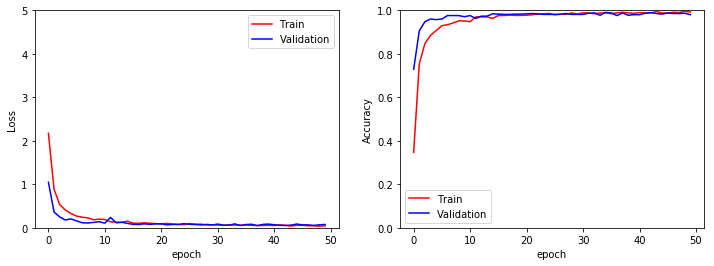

In [14]:
res = train_model(model_cnn, train_generator, validation_generator, num_epoch=50, verbose=1)
plot_results(res)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

# Here the validation is used for testing and this should be changes to a separate test set.
test_generator = train_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical')


In [ ]:
d = {'bicycle':0, 'continue':1, 'crossing':2, 'giveway':3, 'laneend':4, 'limitedtraffic':5, 'noentry':6, 'noparking':7, 'parking':8, 
     'rightofway':9, 'roundabout':10, 'speed':11, 'stop':12, 'trafficdirective':13, 'trafficdirection':14, 'warning':15}
data['labels_num'] = data['label'].map(d, na_action='ignore')

In [ ]:
d_inv = {v: k for k, v in d.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_cnn.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
model_cnn.load_weights('model.h5')

res = train_model(model_cnn, train_generator, validation_generator, num_epoch=150, verbose=1)
plot_results(res)

In [ ]:
from PIL import Image
import pandas as pd
import glob
image_list = []
i = 0
for filepath in glob.glob('./sign_type_data_test/*/*.png', recursive=True): #assuming gif
    newsize = (28,28)
    img = Image.open(filepath).convert('L').resize(newsize)
    path = ('./processed_sign_type_data_test/'+str(i)+'.png')
    img.save(path, 'png')
    filename = path
    label = filepath.split("/")[-2]
#     print(filepath, filename, label)
    image_list.append((filename, label))
    i = i + 1
    
# Create a data frame
chinese_test_data = pd.DataFrame(data=image_list, columns=['image_path', 'label'])